# Train and evaluate NB model on case 14

- Load data
- process data
- train model
    - save model
- load test data
- run inference
- evaluate

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
os.chdir('..')
os.getcwd()

'/home/denny/Documents/mids/w266_NLP/lit-shazam'

In [5]:
from src.data.make_dataset import convert_examples_to_bag_of_words

[nltk_data] Downloading package punkt to /home/denny/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1 Load training data

In [4]:
train_df = pd.read_parquet('./data/processed/train_bal_case14.parquet')
train_df.head()

,Train Data,Train Label
0,"It was from Charley, who had been sent by Cap...",2
1,"""Bacon bun?"" ""Why--yes."" He munched four of th...",0
2,"""Well, what's it about?"" Mr. Weatherbee's voic...",0
3,I did not think Mrs. Gardiner was so little t...,4
4,It may be very inconvenient some years to spar...,4


## Process Training data

In [7]:
# process the same as baseline models
# 0. convert data, labels to list
# 1. tokenize
# 2. stem
train_examples = list(train_df['Train Data'])
train_processed_examples = convert_examples_to_bag_of_words(train_examples)
train_labels = list(train_df['Train Label'])

In [8]:
print('Number of test examples: ', len(train_processed_examples))
len(train_processed_examples) == len(train_labels)

Number of test examples:  5775


True

## Train Naive Bayes Model

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

vectorizer_params = dict()
mnb_params = dict()

nb_pipeline = Pipeline(
[
    ("vect", CountVectorizer(**vectorizer_params)),
    ("clf", MultinomialNB(**mnb_params)),
])

In [11]:
nb_pipeline.fit(train_processed_examples,train_labels)

Pipeline(steps=[('vect', CountVectorizer()), ('clf', MultinomialNB())])

In [12]:
### Save model TODO

## Load test data

In [13]:
test_df = pd.read_parquet('./data/processed/test_case14.parquet')
test_df.head()

,Test Data,Test Label
0,I’d hate to have him get anything on me.” T...,0
1,“On wine?” “Why not?” “It’s the humidity...,1
2,The old rascal!—he said Elizabeth-Jane had die...,2
3,I feel for him sincerely.” A few minutes mo...,4
4,Then the greater right I have on my side when ...,3


In [14]:
test_examples = list(test_df['Test Data'])
test_processed_examples = convert_examples_to_bag_of_words(test_examples)
test_labels = list(test_df['Test Label'])

In [15]:
print('Number of test examples: ', len(test_processed_examples))
len(test_processed_examples) == len(test_labels)

Number of test examples:  3674


True

## Run Inference

In [19]:
y_nbf = nb_pipeline.predict(test_processed_examples)
y_nbf_pred_probs = nb_pipeline.predict_proba(test_processed_examples)
y_nbf[0:5]

array([0, 1, 2, 4, 3])

## Evaluate

In [20]:
# import evaluation metrics
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score, \
precision_score, precision_recall_curve, recall_score, roc_auc_score

              precision    recall  f1-score   support

  Fitzgerald       0.96      0.69      0.80       533
   Hemingway       0.84      0.86      0.85       306
       Hardy       0.84      0.82      0.83       611
     Dickens       0.88      0.83      0.85       940
      Austen       0.73      0.97      0.83       483
  Chesterton       0.74      0.89      0.81       337
 Shakespeare       0.97      0.91      0.94       464

    accuracy                           0.85      3674
   macro avg       0.85      0.85      0.85      3674
weighted avg       0.86      0.85      0.85      3674

------------------------------------------------------------



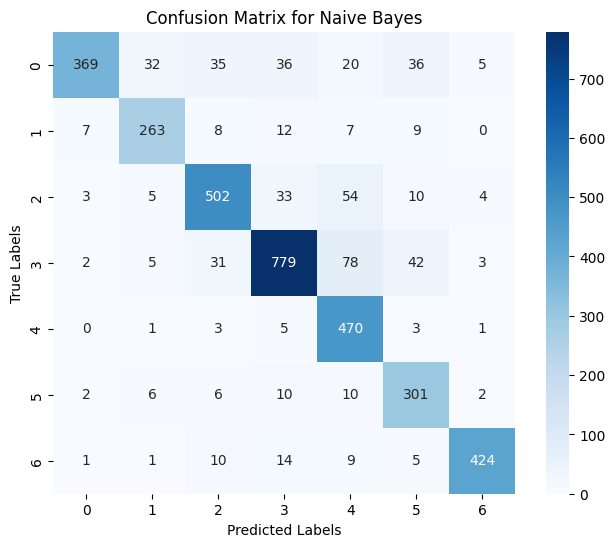

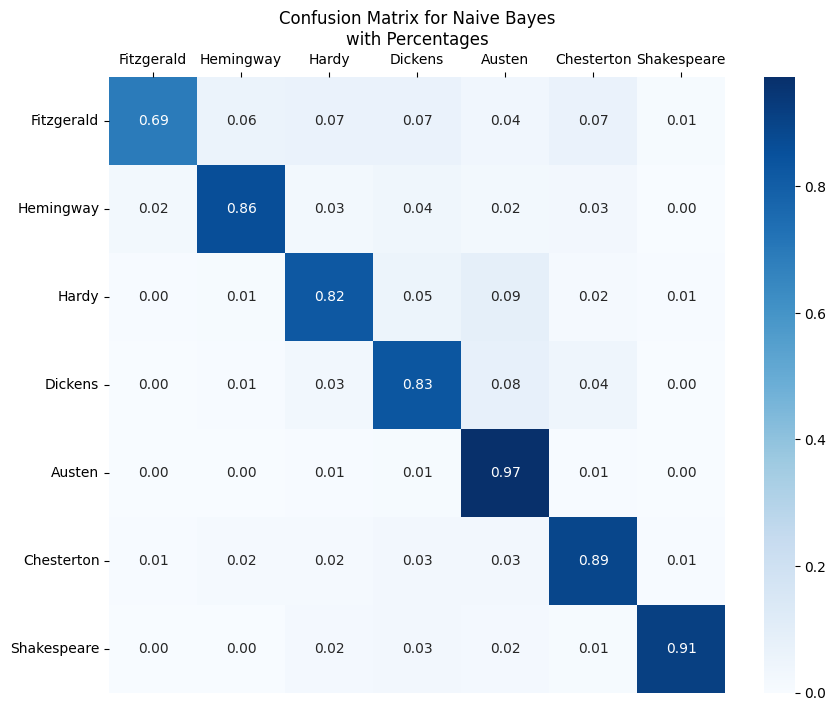

In [21]:
def eval_model(model_name, y_true, y_pred, y_pred_probas, conf_matrix):
    """perform standardized model evaluation
    prints metrics and plots to determine classification performance 
    TODO: returns a dictionary/dataframe of the metrics"""
    
    # TODO: change to load from dictionary
    class_labels = ["Fitzgerald", "Hemingway", "Hardy", "Dickens", "Austen", "Chesterton", "Shakespeare"]

    # print classification report
    print(classification_report(y_true, y_pred, target_names=class_labels))
    print("-" * 60)
    print()

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", square=True)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

    conf_matrix_percentage = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_percentage, annot=True, fmt=".2f", cmap="Blues", square=True, xticklabels=True, yticklabels=True)
    # Set row labels
    
    plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=0)
    plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=0)
    ax = plt.gca()
    ax.xaxis.set_ticks_position("top")

    # Add a title
    plt.title(f"Confusion Matrix for {model_name}\nwith Percentages")
    plt.show()    
    
    # return metrics
    precision = precision_score(y_true, y_pred, average="micro" )
    recall = recall_score(y_true, y_pred, average="micro")
    f1 = f1_score(y_true, y_pred, average="micro") # same as accuracy
    roc_auc = roc_auc_score(y_true, y_pred_probas, average="micro", multi_class="ovr")

    #     ----------------------------------
    #     model_name | f1 score | precision | recall | roc_auc
    metrics_df = pd.DataFrame(data={'f1_score':f1, 
                               'precision':precision, 'recall':recall, 'roc_auc':roc_auc},
                             index=[model_name])
    return metrics_df

nb_metrics = eval_model('Naive Bayes', test_labels, y_nbf, y_nbf_pred_probs, confusion_matrix(test_labels, y_nbf))